In [1]:
import pandas as pd
import os
from glob import glob
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

## load  channel name and cell type info

<!-- 	ON	ON/OFF	OFF	Unknown	Sum
count	32	10	13	52	107 -->


In [2]:
dataset = '20201216'
# dataset = '20201209'

data_path = os.path.join('data', dataset)

In [3]:
dataset = '20180828'

data_path = os.path.join('data', dataset)


width = 8
height = 8

In [4]:
# cloud stim
# ln -s ~/data/cloud_stim data_cloud_stim
data_folder = 'data_cloud_stim'
dataset = '20210203_contrast100'
# dataset = '20210203_contrast50'
width = 52
height = 52

# dataset = '20210113'
# width = 26
# height = 26

data_path = os.path.join(data_folder, dataset)




In [5]:
# read the csv file
info = pd.read_csv(os.path.join(data_path, 'cell_type.csv'))

info.replace('-', 'Unknown', inplace=True)

info

,channel,cell_type
0,12a,ON-OFF
1,12b,ON-OFF
2,13a,ON-OFF
3,13b,Unknown
4,14a,ON
...,...,...
97,85b,Unknown
98,86a,OFF
99,86b,ON
100,87a,ON-OFF


In [6]:
# info.channel.replace('ch_','')

In [7]:
info['cell_type'].value_counts() 

ON         40
ON-OFF     33
Unknown    21
OFF         8
Name: cell_type, dtype: int64

In [8]:
info['cell_type'].value_counts()  / len(info)

ON         0.392157
ON-OFF     0.323529
Unknown    0.205882
OFF        0.078431
Name: cell_type, dtype: float64

## load stim

In [9]:
stim_info_path = glob(os.path.join(data_path,'StimInfo*.mat'))[0]
stim_info_path

'data_cloud_stim/20210203_contrast100/StimInfo_52pix_33um_30Hz_contrast100%.mat'

In [10]:
# read stimulus
import scipy.io as sio
stim = list()
for stim_info in sio.loadmat(stim_info_path)['StimInfo']:
    stim.append(stim_info[0][0])
    # print(stim_info[0][0].shape)
stim = np.array(stim)

In [11]:
stim.shape

(36000, 2704)

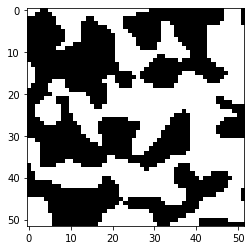

In [12]:
plt.imshow(stim[0,:].reshape(height,width), cmap='gray', vmin=0, vmax=1)

## load spike counts

In [13]:
def count_spikes(spike_times, bins, timestamp_start=0):
    num_bins = bins.shape[0]
    spike_count = np.zeros_like(bins)
    for i in range(num_bins):
        if i == 0:
            continue

        spike_count[i] = np.sum(np.logical_and(spike_times >= timestamp_start + bins[i-1], spike_times < timestamp_start + bins[i]))
    return spike_count

In [14]:
# read spike counts
path = glob(os.path.join(data_path, 'SpikeTrain_'+dataset.split('_')[0],  'SpikeTrain_*'))[0]

# load time stamps
filename = os.path.join(path, 'A1a.mat')
print(filename)
ts = sio.loadmat(filename)['A1a'].ravel()
# print(ts[0], ts[-1], ts.shape)

# load spike times
# channel_names = list()
spike_counts = list()
for i, channel_name in enumerate(tqdm(info['channel'])):
    filename = os.path.join(path, 'ch_' + channel_name)
    # print(filename)
    spike_time = sio.loadmat(filename)['ch_' + channel_name].ravel()

    # count spikes
    spike_counts.append(count_spikes(spike_time, ts))

spike_counts = np.array(spike_counts)

  0%|          | 0/102 [00:00<?, ?it/s]

data_cloud_stim/20210203_contrast100/SpikeTrain_20210203/SpikeTrain_ND2_52pix_33um_30Hz_contrast100%/A1a.mat


100%|██████████| 102/102 [05:07<00:00,  3.02s/it]


In [15]:
spike_counts.shape

(102, 36000)

(array([2317700.,  908847.,  297527.,   96688.,   33691.,   11779.,
           4070.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5]),
 <BarContainer object of 7 artists>)

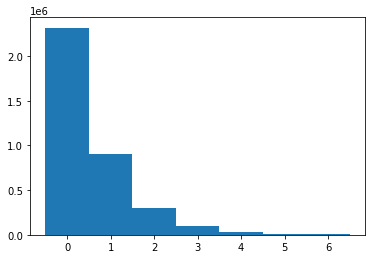

In [16]:
plt.hist(spike_counts.ravel(), [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])

## save to npz and csv

put these files under `data`

In [17]:
np.savez_compressed(dataset, dataset=dataset, stim=stim, spike_counts=spike_counts)
# if len(set(stim.ravel()))==2: # binary stim
#     np.savez_compressed(dataset, dataset=dataset, stim=stim.astype(int), spike_counts=spike_counts)
# else:
#     np.savez_compressed(dataset, dataset=dataset, stim=stim, spike_counts=spike_counts)

In [18]:
info.to_csv(dataset+'_info.csv', index=None)